In [33]:
from src.dataloader import *

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn


import tensorflow as tf
import keras
import keras.layers as layers
from keras.losses import BinaryCrossentropy


In [34]:
tf.random.set_seed(42)

# Import des données

In [35]:
label_attribution=LabelAttribution(path_image_google="C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", 
                                   path_mask_google='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/mask/',
                                   path_metadata='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/metadata.csv',
                                   colonne_identifiant='identifiant',
                                   path_export_train_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps",
                                   path_image_ign='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/img',
                                   path_mask_ign='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/mask/',
                                   use_img_google=True,
                                   use_img_ign=False
                                    )

In [36]:
label_attribution.run()

Le LeNET5 a été conçu pour prendre en entrée des images de dimension 28*28. On passe donc les images 400 x 400 en 28 x 28. On convertit ensuite ces dernières en tenseurs. 

In [37]:
path_train="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                           ]))
transformed_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                           ]))

In [38]:
print("Nombre d'images dans le train: {}".format(transformed_train_dataset.__len__()))
print("Nombre d'images dans le test: {}".format(transformed_test_dataset.__len__()))

Nombre d'images dans le train: 23045
Nombre d'images dans le test: 5762


In [39]:
train_dataloader = DataLoader(transformed_train_dataset, batch_size=23045, shuffle=True)
test_dataloader = DataLoader(transformed_test_dataset, batch_size=5762, shuffle=True)

# LeNet5: implémentation et apprentissage

## Absence de data augmentations

On entraîne le LeNet5 sans data augmentations. Nous fixons les hyper-paramètres de façon arbitraire dans un premier temps:
* Learning rate: 0,01
* Dropout: 0,2
* epochs: 10
* batch size: 32

In [40]:
X_train, Y_train=next(iter(train_dataloader))
X_test, Y_test=next(iter(test_dataloader))

X_train_permute=X_train.permute(0, 2, 3,1)
X_test_permute=X_test.permute(0, 2, 3,1)

In [41]:
from src.lenet5 import buildModel

model_init=buildModel()

history=model_init.fit(x=X_train_permute.numpy(), y=Y_train.numpy(),
	validation_data=(X_test_permute.numpy(), Y_test.numpy()),
	batch_size=32,
	epochs=10)

Epoch 1/10
721/721 [==============================] - 5s 6ms/step - loss: 0.6307 - Accuracy: 0.6594 - recall_m: 0.7991 - precision_m: 0.6604 - f1_m: 0.7005 - val_loss: 0.6259 - val_Accuracy: 0.6538 - val_recall_m: 0.4340 - val_precision_m: 0.8459 - val_f1_m: 0.5653
Epoch 2/10
721/721 [==============================] - 4s 6ms/step - loss: 0.5598 - Accuracy: 0.7301 - recall_m: 0.7480 - precision_m: 0.7504 - f1_m: 0.7390 - val_loss: 0.5626 - val_Accuracy: 0.7090 - val_recall_m: 0.8901 - val_precision_m: 0.6702 - val_f1_m: 0.7607
Epoch 3/10
721/721 [==============================] - 5s 7ms/step - loss: 0.5233 - Accuracy: 0.7582 - recall_m: 0.7766 - precision_m: 0.7724 - f1_m: 0.7663 - val_loss: 0.4916 - val_Accuracy: 0.7872 - val_recall_m: 0.7719 - val_precision_m: 0.8150 - val_f1_m: 0.7889
Epoch 4/10
721/721 [==============================] - 4s 6ms/step - loss: 0.4734 - Accuracy: 0.7971 - recall_m: 0.8170 - precision_m: 0.8058 - f1_m: 0.8048 - val_loss: 0.4456 - val_Accuracy: 0.8164 - va

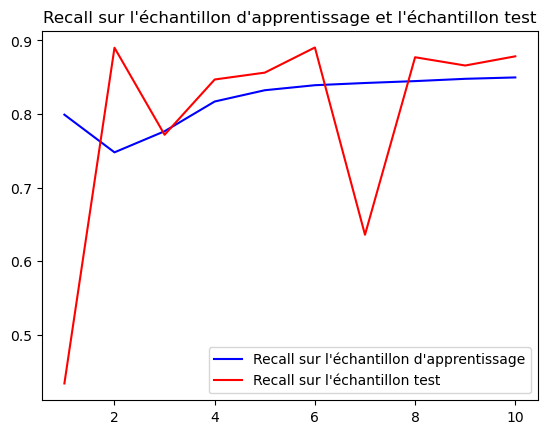

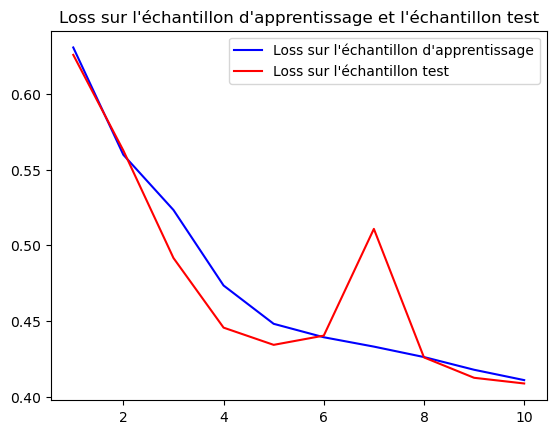

In [42]:
recall = history.history['recall_m']
val_recall = history.history['val_recall_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(recall) + 1)

plt.plot(epochs, recall, 'b', label="Recall sur l'échantillon d'apprentissage")
plt.plot(epochs, val_recall, 'b', label="Recall sur l'échantillon test", color="red")
plt.title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label="Loss sur l'échantillon d'apprentissage")
plt.plot(epochs, val_loss, 'b', label="Loss sur l'échantillon test", color="red")
plt.title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
plt.legend()
plt.show()

In [43]:
loss, accuracy, recall, precision, f1score = model_init.evaluate(X_test_permute.numpy(), Y_test.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss,3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy,3)))
print("Recall sur l'échantillon test: {}".format(round(recall,3)))
print("Precision sur l'échantillon test: {}".format(round(precision,3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score,3)))

Loss sur l'échantillon test: 0.409
Accuracy sur l'échantillon test: 0.833
Recall sur l'échantillon test: 0.878
Precision sur l'échantillon test: 0.816
F1-score sur l'échantillon test: 0.842


In [44]:
prob_predict = model_init.predict(X_test_permute.numpy())
y_pred = (np.squeeze(prob_predict) > 0.5).astype("int32")

181/181 [==============================] - 1s 3ms/step


In [45]:
y_pred

array([1, 1, 0, ..., 1, 0, 1])

In [46]:
unique, counts = np.unique(y_pred, return_counts=True)
res=dict(zip(unique, counts))
print("Nombre d'images prédites avec panneaux: {}".format(res[1]))
print("Nombre d'images prédites sans panneau: {}".format(res[0]))

Nombre d'images prédites avec panneaux: 3358
Nombre d'images prédites sans panneau: 2404


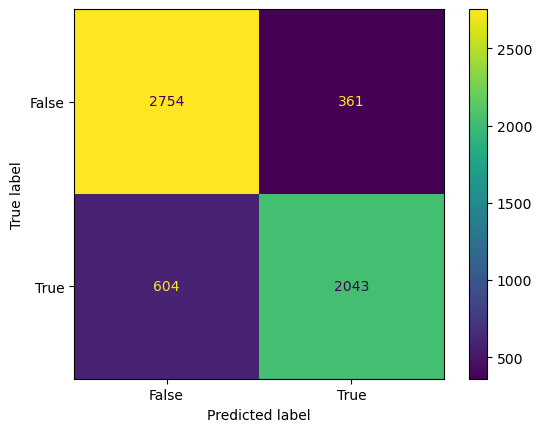

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

r = confusion_matrix(Y_test, y_pred)
r = np.flip(r)

cm_display = ConfusionMatrixDisplay(confusion_matrix = r, display_labels = [False, True])
cm_display.plot()
plt.show()

In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

FPR, TPR, thresholds_keras = roc_curve(Y_test.numpy(), prob_predict)
AUC = auc(FPR, TPR)
print("AUC: {}".format(round(AUC, 2)))

AUC: 0.9


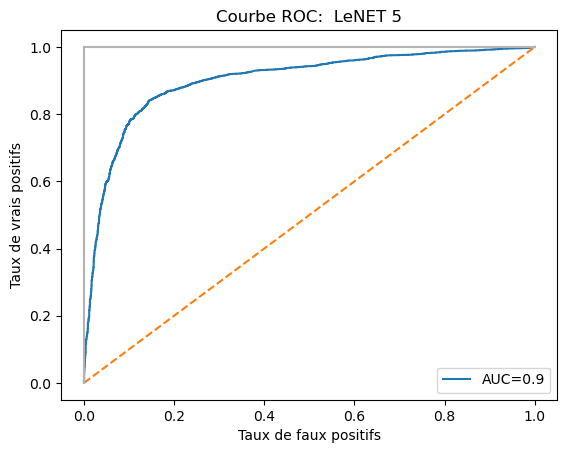

In [49]:
from matplotlib import pyplot as plt
# plot the roc curve for the model

plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()

## Ajout de data augmentations

In [50]:
transformed_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.5, 0.5)),
                                               transforms.RandomCrop(20),
                                               transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomVerticalFlip(p=0.5),
                                               transforms.RandomRotation(degrees = (0,180)),
                                               transforms.Resize(28),
                                               transforms.ToTensor(), 

                                           ]))

#On resize uniquement sur le test
transformed_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                           ]))

In [51]:
train_dataloader = DataLoader(transformed_train_dataset, batch_size=23045, shuffle=True)
test_dataloader = DataLoader(transformed_test_dataset, batch_size=5762, shuffle=True)

On normalise les données d'apprentissage et de test

In [52]:
mean_train, std_train = mean_std(train_dataloader)
print("Moyenne par channel: {}".format(mean_train.tolist()))
print("Ecart-type par channel: {}".format(std_train.tolist()))

Moyenne par channel: [0.2969153821468353, 0.2965591847896576, 0.296100378036499]
Ecart-type par channel: [0.1898174285888672, 0.18907228112220764, 0.18922674655914307]


In [53]:
mean_test, std_test = mean_std(test_dataloader)
print("Moyenne par channel: {}".format(mean_test.tolist()))
print("Ecart-type par channel: {}".format(std_test.tolist()))

Moyenne par channel: [0.3499933183193207, 0.3576659560203552, 0.30810657143592834]
Ecart-type par channel: [0.16761955618858337, 0.14885342121124268, 0.1473139077425003]


In [54]:
normalized_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.5, 0.5)),
                                               transforms.RandomCrop(20),
                                               transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomVerticalFlip(p=0.5),
                                               transforms.RandomRotation(degrees = (0,180)),
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = mean_train.tolist(),
                                                                    std= std_train.tolist()), 

                                           ]))


normalize_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = mean_test.tolist(),
                                                                    std= std_test.tolist()), 
                                           ]))
train_dataloader_augmente = DataLoader(normalized_train_dataset, batch_size=23045, shuffle=True)
test_dataloader_augmente = DataLoader(normalize_test_dataset, batch_size=5762, shuffle=True)

## Apprentissage avec data augmentations

In [55]:
X_train_augmente, Y_train_augmente=next(iter(train_dataloader_augmente))
X_test_augmente, Y_test_augmente=next(iter(test_dataloader_augmente))

X_train_augmente_permute=X_train_augmente.permute(0, 2, 3,1)
X_test_augmente_permute=X_test_augmente.permute(0, 2, 3,1)

In [56]:
model_augmente=buildModel()

history_augmente=model_augmente.fit(x=X_train_augmente_permute.numpy(), y=Y_train_augmente.numpy(),
	validation_data=(X_test_augmente_permute.numpy(), Y_test_augmente.numpy()),
	batch_size=32,
	epochs=10)

Epoch 1/10
721/721 [==============================] - 6s 7ms/step - loss: 0.6696 - Accuracy: 0.5885 - recall_m: 0.6776 - precision_m: 0.5997 - f1_m: 0.6283 - val_loss: 0.6304 - val_Accuracy: 0.6637 - val_recall_m: 0.7710 - val_precision_m: 0.6641 - val_f1_m: 0.7070
Epoch 2/10
721/721 [==============================] - 5s 6ms/step - loss: 0.6601 - Accuracy: 0.6054 - recall_m: 0.6871 - precision_m: 0.6161 - f1_m: 0.6421 - val_loss: 0.6310 - val_Accuracy: 0.6697 - val_recall_m: 0.7725 - val_precision_m: 0.6710 - val_f1_m: 0.7114
Epoch 3/10
721/721 [==============================] - 5s 7ms/step - loss: 0.6531 - Accuracy: 0.6170 - recall_m: 0.6858 - precision_m: 0.6274 - f1_m: 0.6477 - val_loss: 0.6189 - val_Accuracy: 0.6859 - val_recall_m: 0.7816 - val_precision_m: 0.6834 - val_f1_m: 0.7232
Epoch 4/10
721/721 [==============================] - 5s 7ms/step - loss: 0.6385 - Accuracy: 0.6432 - recall_m: 0.6846 - precision_m: 0.6572 - f1_m: 0.6625 - val_loss: 0.6022 - val_Accuracy: 0.7060 - va

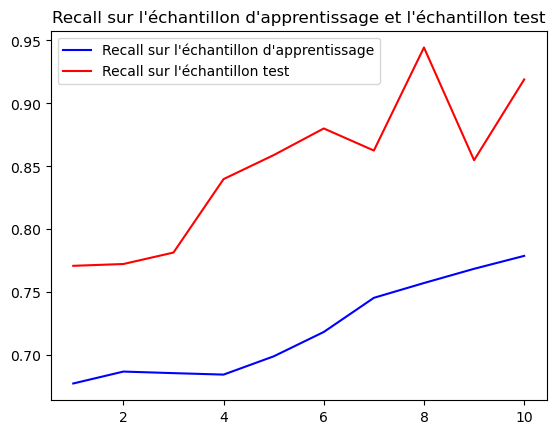

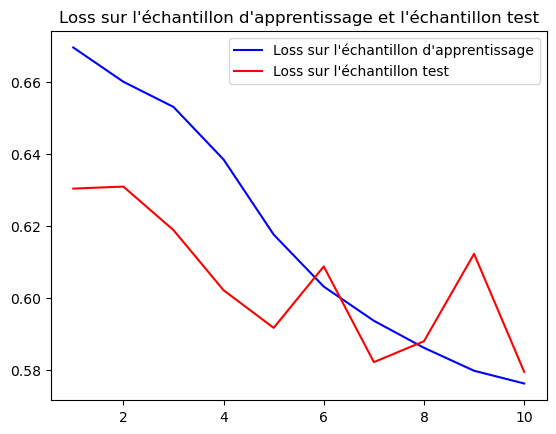

In [57]:
recall_augmente = history_augmente.history['recall_m']
val_recall_augmente = history_augmente.history['val_recall_m']
loss_augmente = history_augmente.history['loss']
val_loss_augmente = history_augmente.history['val_loss']
epochs_augmente = range(1, len(recall_augmente) + 1)

plt.plot(epochs_augmente, recall_augmente, 'b', label="Recall sur l'échantillon d'apprentissage")
plt.plot(epochs_augmente, val_recall_augmente, 'b', label="Recall sur l'échantillon test", color="red")
plt.title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
plt.legend()
plt.figure()
plt.plot(epochs_augmente, loss_augmente, 'b', label="Loss sur l'échantillon d'apprentissage")
plt.plot(epochs_augmente, val_loss_augmente, 'b', label="Loss sur l'échantillon test", color="red")
plt.title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
plt.legend()
plt.show()

In [58]:
loss_augmente, accuracy_augmente, recall_augmente, precision_augmente, f1score_augmente = model_augmente.evaluate(X_test_augmente_permute.numpy(), Y_test_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_augmente,3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_augmente,3)))
print("Recall sur l'échantillon test: {}".format(round(recall_augmente,3)))
print("Precision sur l'échantillon test: {}".format(round(precision_augmente,3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_augmente,3)))

Loss sur l'échantillon test: 0.58
Accuracy sur l'échantillon test: 0.702
Recall sur l'échantillon test: 0.919
Precision sur l'échantillon test: 0.661
F1-score sur l'échantillon test: 0.765


In [59]:
prob_predict_augmente = model_augmente.predict(X_test_augmente_permute.numpy())
y_pred_augmente = (np.squeeze(prob_predict_augmente) > 0.5).astype("int32")

181/181 [==============================] - 1s 3ms/step


In [60]:
unique_augmente, counts_augmente = np.unique(y_pred_augmente, return_counts=True)
res_augmente=dict(zip(unique_augmente, counts_augmente))
print("Nombre d'images prédites avec panneaux: {}".format(res_augmente[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_augmente[0]))

Nombre d'images prédites avec panneaux: 4322
Nombre d'images prédites sans panneau: 1440


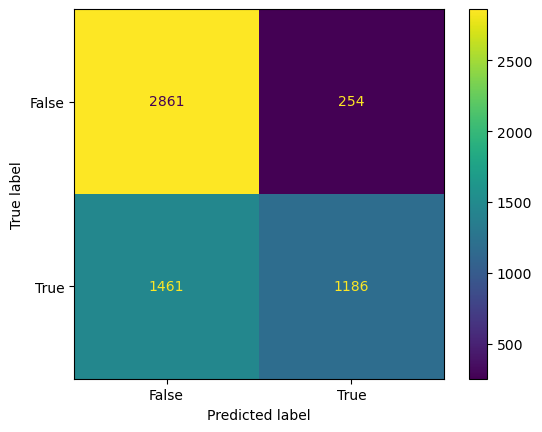

In [61]:
r = confusion_matrix(Y_test_augmente, y_pred_augmente)
r = np.flip(r)

cm_display = ConfusionMatrixDisplay(confusion_matrix = r, display_labels = [False, True])
cm_display.plot()
plt.show()

In [62]:
FPR_augmente, TPR_augmente, thresholds_keras_augmente = roc_curve(Y_test_augmente.numpy(), prob_predict_augmente)
AUC_augmente = auc(FPR_augmente, TPR_augmente)
print("AUC: {}".format(round(AUC_augmente, 2)))

AUC: 0.77


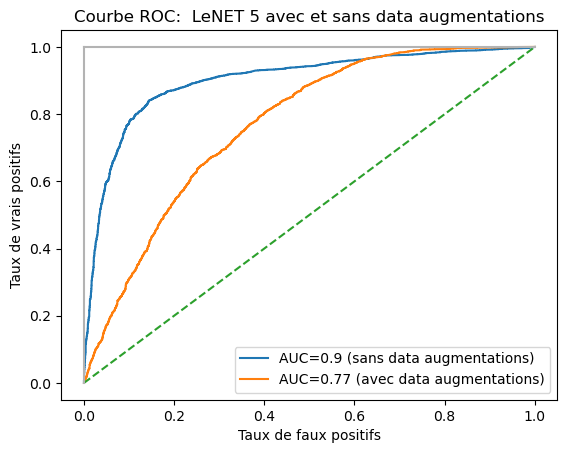

In [63]:
plt.title('Courbe ROC:  LeNET 5 avec et sans data augmentations')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC,2))+" (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC="+str(round(AUC_augmente,2))+" (avec data augmentations)")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()

# Hyperparamétrisation du modèle: random search

https://pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/

In [64]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2,0.3, 0.4, 0.5,0.6,0.7,0.8]
batchSize = [4, 8, 16, 32, 64, 128, 256]
epochs = [10, 20, 30, 40,50]

grid = dict(
	learnRate=learnRate,
	dropout=dropout,
	batch_size=batchSize,
	epochs=epochs
)

model = KerasClassifier(build_fn=buildModel, verbose=1)
#grid = GridSearchCV(estimator=model, param_grid=hyperMatrix)

#n_iter: nombre de modèles entrainés
searcher = RandomizedSearchCV(estimator=model, cv=5, n_iter= 10, param_distributions=grid, scoring='recall')
searchResults = searcher.fit(X_train_augmente_permute.numpy(), Y_train_augmente.numpy())

Epoch 1/20
2305/2305 [==============================] - 7s 3ms/step - loss: 0.6653 - Accuracy: 0.5918 - recall_m: 0.6817 - precision_m: 0.6045 - f1_m: 0.6116
Epoch 2/20
2305/2305 [==============================] - 7s 3ms/step - loss: 0.6483 - Accuracy: 0.6196 - recall_m: 0.6864 - precision_m: 0.6302 - f1_m: 0.6261
Epoch 3/20
2305/2305 [==============================] - 6s 3ms/step - loss: 0.6164 - Accuracy: 0.6643 - recall_m: 0.7096 - precision_m: 0.6736 - f1_m: 0.6617
Epoch 4/20
2305/2305 [==============================] - 6s 3ms/step - loss: 0.5927 - Accuracy: 0.6817 - recall_m: 0.7558 - precision_m: 0.6796 - f1_m: 0.6896
Epoch 5/20
2305/2305 [==============================] - 7s 3ms/step - loss: 0.5791 - Accuracy: 0.6885 - recall_m: 0.7733 - precision_m: 0.6811 - f1_m: 0.6990
Epoch 6/20
2305/2305 [==============================] - 6s 3ms/step - loss: 0.5680 - Accuracy: 0.6992 - recall_m: 0.7870 - precision_m: 0.6869 - f1_m: 0.7087
Epoch 7/20
2305/2305 [==============================

In [65]:
# summarize grid search information
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_
print("[INFO] best score is {} using {}".format(round(bestScore,3),
	bestParams))

[INFO] best score is 0.796 using {'learnRate': 0.001, 'epochs': 10, 'dropout': 0.8, 'batch_size': 64}


In [66]:
searchResults.cv_results_["mean_test_score"]

array([0.64499062, 0.62882124, 0.71428442, 0.69682641, 0.68366767,
       0.73096798, 0.7960505 , 0.67276681, 0.72285478, 0.6754801 ])

# Résultats sur le modèle optimisé

In [67]:
best_model=buildModel(learnRate=bestParams['learnRate'], dropout=bestParams['dropout'])

best_model.fit(x=X_train_augmente_permute.numpy(), y=Y_train_augmente.numpy(),
	validation_data=(X_test_augmente_permute.numpy(), Y_test_augmente.numpy()),
	batch_size=bestParams['batch_size'],
	epochs=bestParams['epochs'])

Epoch 1/10
361/361 [==============================] - 5s 13ms/step - loss: 0.6710 - Accuracy: 0.5871 - recall_m: 0.6885 - precision_m: 0.5966 - f1_m: 0.6351 - val_loss: 0.6414 - val_Accuracy: 0.6453 - val_recall_m: 0.7317 - val_precision_m: 0.6519 - val_f1_m: 0.6863
Epoch 2/10
361/361 [==============================] - 4s 11ms/step - loss: 0.6626 - Accuracy: 0.6000 - recall_m: 0.6920 - precision_m: 0.6081 - f1_m: 0.6437 - val_loss: 0.6396 - val_Accuracy: 0.6496 - val_recall_m: 0.7411 - val_precision_m: 0.6544 - val_f1_m: 0.6919
Epoch 3/10
361/361 [==============================] - 4s 10ms/step - loss: 0.6603 - Accuracy: 0.6028 - recall_m: 0.6929 - precision_m: 0.6104 - f1_m: 0.6454 - val_loss: 0.6387 - val_Accuracy: 0.6609 - val_recall_m: 0.7304 - val_precision_m: 0.6703 - val_f1_m: 0.6956
Epoch 4/10
361/361 [==============================] - 4s 10ms/step - loss: 0.6584 - Accuracy: 0.6020 - recall_m: 0.6876 - precision_m: 0.6091 - f1_m: 0.6425 - val_loss: 0.6369 - val_Accuracy: 0.6499 

In [68]:
loss_best, accuracy_best, recall_best, precision_best, f1score_best = best_model.evaluate(X_test_permute.numpy(), Y_test.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_best,3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_best,3)))
print("Recall sur l'échantillon test: {}".format(round(recall_best,3)))
print("Precision sur l'échantillon test: {}".format(round(precision_best,3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_best,3)))

Loss sur l'échantillon test: 0.675
Accuracy sur l'échantillon test: 0.543
Recall sur l'échantillon test: 0.994
Precision sur l'échantillon test: 0.539
F1-score sur l'échantillon test: 0.695


In [69]:
best_predict = best_model.predict(X_test_permute.numpy())
best_y_pred = (np.squeeze(best_predict) > 0.5).astype("int32")

181/181 [==============================] - 1s 3ms/step


In [70]:
uni_best, compteur_best = np.unique(best_y_pred, return_counts=True)
res_best=dict(zip(uni_best, compteur_best))
print("Nombre d'images prédites avec panneaux: {}".format(res_best[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_best[0]))

Nombre d'images prédites avec panneaux: 5748
Nombre d'images prédites sans panneau: 14


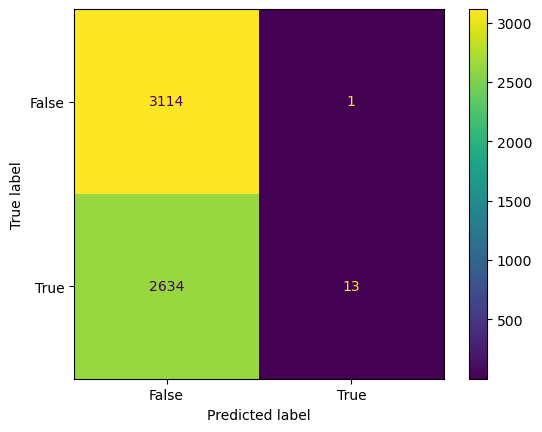

In [71]:
r = confusion_matrix(Y_test, best_y_pred)
r = np.flip(r)

cm_display = ConfusionMatrixDisplay(confusion_matrix = r, display_labels = [False, True])
cm_display.plot()
plt.show()

In [72]:
FPR_best, TPR_best, thresholds_keras_best = roc_curve(Y_test.numpy(), best_predict)
AUC_best = auc(FPR_best, TPR_best)
print("AUC: {}".format(round(AUC_best, 2)))

AUC: 0.69


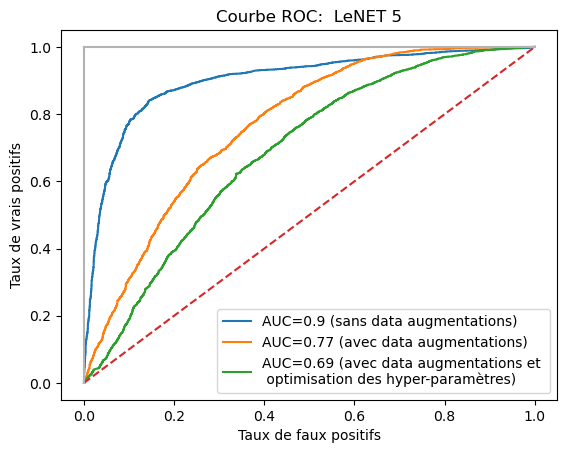

In [75]:
plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC,2))+" (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC="+str(round(AUC_augmente,2))+" (avec data augmentations)")
plt.plot(FPR_best, TPR_best, label="AUC="+str(round(AUC_best,2))+" (avec data augmentations et \n optimisation des hyper-paramètres)")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()